In [1]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.ddpg import config

# 0. Plot Setting

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# 1. Model Setting

## 1.1 Load Config

In [3]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [4]:
ntb_mode = False

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'std_coeff': 1e-2
})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,
})

learn_kwargs.update({
    'total_timesteps': 1500
})

if ntb_mode:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 2]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    model_kwargs['policy_kwargs'].update({
        'net_arch': [],
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 2,
        'net_arch': [32, 64]
    })

In [6]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarketEval instance>
learn_kwargs['tb_log_name']: ddpg_220612-1428
learn_kwargs['eval_log_path']: ../logs/tb_logs/ddpg_220612-1428_1


In [7]:
pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'n_assets': 1000,
 'n_periods': 30,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [8]:
pprint(model_kwargs)

{'action_noise': NormalActionNoise(mu=0.0, sigma=0.1),
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'env': <Env.env.BSMarket object at 0x000002F35FB1D3A0>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x000002F35E855280>,
 'learning_starts': 300,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.ddpg.policies.DoubleDDPGPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'actor_net_kwargs': None,
                   'critic_net_kwargs': None,
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
                                                 'features_out': 2,
                                                 'last_activat

In [9]:
pprint(learn_kwargs)

{'callback': <Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000002F35FB098B0>,
 'eval_env': <Env.env.BSMarketEval object at 0x000002F35FB1D430>,
 'eval_freq': 30,
 'eval_log_path': '../logs/tb_logs/ddpg_220612-1428_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'ddpg_220612-1428',
 'total_timesteps': 1500}


## 1.2 Make env, model

In [10]:
from Algorithms.ddpg import DDPG
# from Algorithms.ddpg.double_ddpg import DDPG

model = DDPG(**model_kwargs)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
model.policy

DoubleDDPGPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
        (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Linear(in_features=64, out_features=2, bias=True)
        (8): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=2, out_features=1, bias=True)
      (1): Tanh()
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
  )
  (actor_target): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, tr

# 2. Learning

In [11]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs\ddpg_220609-1512_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.03 +/- 0.00
Episode length: 29.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 29       |
|    mean_reward     | -0.0306  |
| time/              |          |
|    total timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.03 +/- 0.00
Episode length: 29.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 29       |
|    mean_reward     | -0.0314  |
| time/              |          |
|    total timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.03 +/- 0.00
Episode length: 29.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 29       |
|    mea

In [12]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.ddpg.callbacks.ReportCallbacks object at 0x00000208501FE550> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/ddpg_220609-1512_1/config.yaml was saved.


# 3. P&L Evaluation

In [11]:
# model = model.load('../logs/tb_logs/ddpg_220607-2214_stable'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220607-2124_ntb_delta'+'/best_model')
# model = model.load('../logs/tb_logs/ddpg_220608-2037_1'+'/best_model')
model = model.load('../logs/tb_logs/ddpg_220608-2109_ntb_delta'+'/best_model')
# model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
# print(learn_kwargs['eval_log_path'] + '/best_model')

In [12]:
eval_env = learn_kwargs['eval_env']
eval_env

In [14]:
import numpy as np

# random_pnl = np.mean([eval_env.pnl_eval() for _ in range(30)], axis=0)
# delta_pnl = np.mean([eval_env.delta_eval() for _ in range(30)], axis=0)
# rl_pnl = np.mean([eval_env.pnl_eval(model) for _ in range(30)], axis=0)

# random_pnl = np.load('best_results/random_pnl.npy')
delta_pnl = np.load('best_results/delta_pnl.npy')
rl_pnl = np.load('best_results/rl_pnl.npy')

In [15]:
# np.save('best_results/random_pnl', random_pnl)
# np.save('best_results/delta_pnl', delta_pnl)
# np.save('best_results/rl_pnl', rl_pnl)

In [16]:
ntb_pnl = np.mean([eval_env.pnl_eval(model) for _ in range(30)], axis=0)

In [17]:
import numpy as np

def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return mean - 0.02 * std , (mean, std)

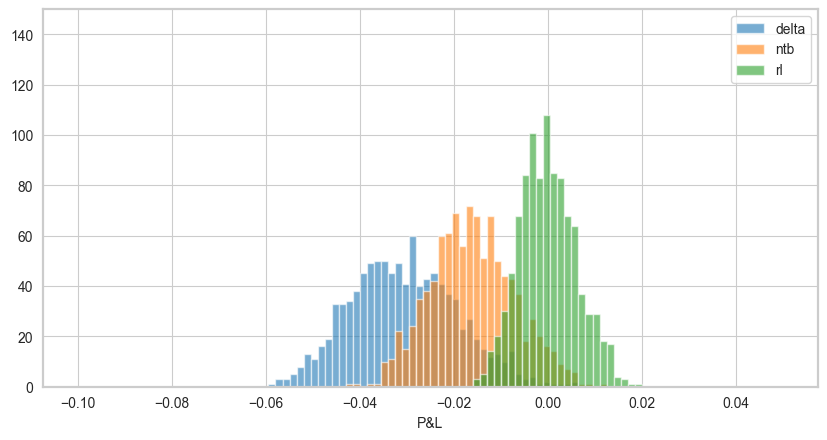

delta:	-0.0309, -0.0307, 0.0114
ntb_pnl:		-0.0163, -0.0161, 0.0089
rl:		-0.0002, -0.0000, 0.0060
0.014618505642230033
0.016106425672000036


In [18]:
plt.xlabel('P&L')
# plt.hist(random_pnl, bins=100, range=(-0.25, 0.05), alpha=0.6, label='random')
# plt.hist(random_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='random')
plt.hist(delta_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta')
plt.hist(ntb_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='ntb')
plt.hist(rl_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='rl')
plt.ylim(0, 150)
plt.legend()
plt.show()

r1, (m1, s1) = pnl_reward(delta_pnl)
r2, (m2, s2) = pnl_reward(ntb_pnl)
r3, (m3, s3) = pnl_reward(rl_pnl)
print(f'delta:\t{r1:.4f}, {m1:.4f}, {s1:.4f}')
print(f'ntb_pnl:\t\t{r2:.4f}, {m2:.4f}, {s2:.4f}')
print(f'rl:\t\t{r3:.4f}, {m3:.4f}, {s3:.4f}')
print((r2-r1))
print((r3-r2))

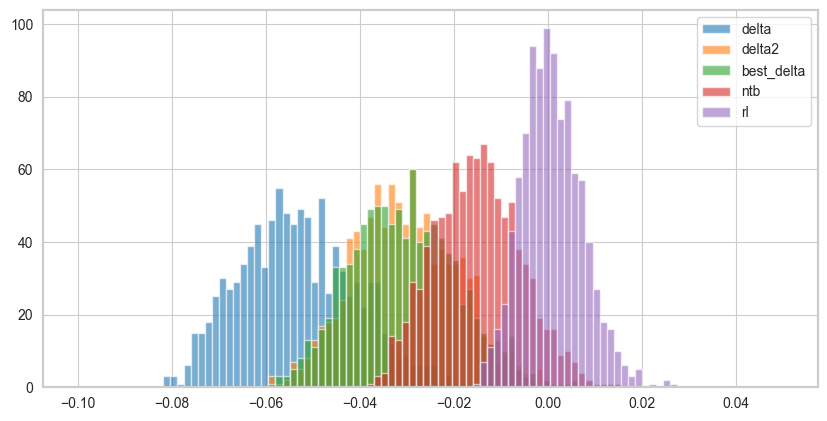

In [17]:
plt.hist(delta_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta')
plt.hist(np.mean([eval_env.delta_eval2() for _ in range(30)], axis=0), bins=100, range=(-0.1, 0.05), alpha=0.6, label='delta2')
plt.hist(np.load('best_results/delta_pnl.npy'), bins=100, range=(-0.1, 0.05), alpha=0.6, label='best_delta')
plt.hist(ntb_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='ntb')
plt.hist(rl_pnl, bins=100, range=(-0.1, 0.05), alpha=0.6, label='rl')
plt.legend()
plt.show()